# Performing z-mu cosmology fitting

In [1]:
import cosmographi as cg
import caskade as ck
import jax.numpy as jnp
import jax
from functools import partial
import matplotlib.pyplot as plt
from time import time
import corner
import numpy as np
from tqdm import tqdm

print(jax.config.jax_enable_x64)

True


## Making a SN sample

In [2]:
# Define the simulator
z_max = 2.0
cosmology = cg.Cosmology()
rateIa = cg.sn.SNRateConst(cosmology, 1e-4, z_min=0.0, z_max=z_max, name="rateIa")
rateIbc = cg.sn.SNRateConst(cosmology, 5e-5, z_min=0.0, z_max=z_max, name="rateIbc")
ratecombined = cg.sn.CombinedSNRate((rateIa, rateIbc), z_min=0.0, z_max=z_max, cosmology=cosmology)
# detect_Ia = cg.sn.MuNCDFDetect(threshold=15, scale=0.1 * jnp.sqrt(8 / jnp.pi), name="detectIa")
# detect_Ibc = cg.sn.MuNCDFDetect(threshold=14, scale=0.13 * jnp.sqrt(8 / jnp.pi), name="detectIbc")
detect_Ia = cg.sn.MuSigmoidDetect(threshold=15, scale=0.1, name="detectIa")
detect_Ibc = cg.sn.MuSigmoidDetect(threshold=14, scale=0.2, name="detectIbc")

# Define sampling parameters
n_samples = 500
var_z_Ia = lambda z: 0.05**2 * jnp.ones_like(z)
var_mu_Ia = lambda z: 0.1**2 * jnp.ones_like(z)
cov_Ia = lambda key, var_z, var_mu: jnp.zeros(
    var_mu.shape
)  # jax.random.uniform(key, var_m.shape, minval=0, maxval=jnp.sqrt(var_m * var_z) * 0.7)
var_z_Ibc = lambda z: 0.2**2 * jnp.ones_like(z)
var_mu_Ibc = lambda z: 1.0**2 * jnp.ones_like(z)
cov_Ibc = lambda key, var_z, var_mu: jnp.zeros(
    var_mu.shape
)  # jax.random.uniform(key, var_m.shape, minval=0, maxval=jnp.sqrt(var_m * var_z) * 0.7)

# Sample SN
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
# sample SN redshifts
z = ratecombined.sample(subkey, n_samples)
# sample SN types
t = []
for i in tqdm(range(n_samples)):
    key, subkey = jax.random.split(key)
    t.append(ratecombined.sample_type(subkey, z[i]))
t = jnp.array(t)
# compute true distance modulus
DL = jax.vmap(cosmology.luminosity_distance)(z)
mu = 5 * jnp.log10(DL) - 5
# determine observational uncertainties
var_z = jnp.stack((var_z_Ia(z), var_z_Ibc(z)), axis=-1)  # (N, t)
var_mu = jnp.stack((var_mu_Ia(z), var_mu_Ibc(z)), axis=-1)  # (N, t)
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
cov = jnp.stack(
    (cov_Ia(subkey1, var_mu[:, 0], var_z[:, 0]), cov_Ibc(subkey2, var_mu[:, 1], var_z[:, 1])),
    axis=-1,
)  # (N, t)
# sample observed apparent magnitudes
key, subkey = jax.random.split(key)
samp_varz = jnp.where(t == 0, var_z[:, 0], var_z[:, 1])
samp_varmu = jnp.where(t == 0, var_mu[:, 0], var_mu[:, 1])
samp_cov = jnp.where(t == 0, cov[:, 0], cov[:, 1])
obs = jax.random.multivariate_normal(
    key,
    mean=jnp.stack((z, mu), axis=-1),
    cov=jnp.stack(
        (jnp.stack((samp_varz, samp_cov), axis=-1), jnp.stack((samp_cov, samp_varmu), axis=-1)),
        axis=-1,
    ),
)
z_obs = obs[:, 0]
mu_obs = obs[:, 1]
obs_mean = obs  # (N, 2)
obs_cov = jnp.stack(
    (
        jnp.stack((var_z, cov), axis=-1),
        jnp.stack((cov, var_mu), axis=-1),
    ),
    axis=-1,
)  # (N, t, 2, 2)
# sample detections
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
detected = jnp.where(
    t == 0, detect_Ia.sample(subkey1, z, mu_obs), detect_Ibc.sample(subkey2, z, mu_obs)
)

# Keep only detected SNe
obs_meanD = obs_mean[detected]
obs_covD = obs_cov[detected]

100%|██████████| 500/500 [00:01<00:00, 341.72it/s]


Number of detected SNe: 209 / 500


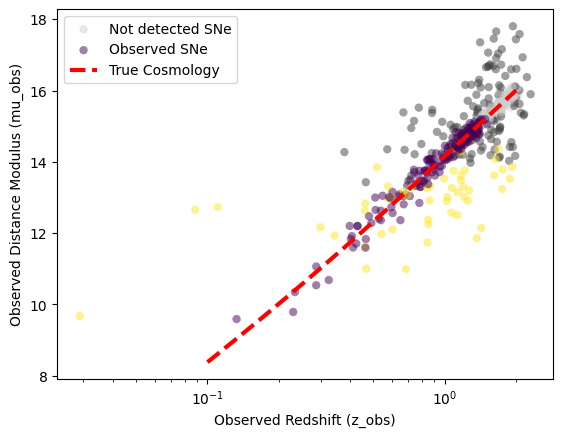

In [3]:
# plot samples
print(f"Number of detected SNe: {jnp.sum(detected)} / {n_samples}")
plt.scatter(
    z_obs[~detected],
    mu_obs[~detected],
    c=plt.get_cmap("Greys")(0.5 * t[~detected] + 0.3),
    alpha=0.5,
    label="Not detected SNe",
    linewidth=0,
)
plt.scatter(
    z_obs[detected],
    mu_obs[detected],
    c=t[detected],
    cmap="viridis",
    alpha=0.5,
    label="Observed SNe",
    linewidth=0,
)
z_line = jnp.linspace(0.1, z_max, 1000)
mu_base = 5 * jnp.log10(jax.vmap(cosmology.luminosity_distance)(z_line)) - 5
plt.plot(
    z_line,
    mu_base,
    "r--",
    label="True Cosmology",
    linewidth=3,
)
plt.xlabel("Observed Redshift (z_obs)")
plt.xscale("log")
plt.ylabel("Observed Distance Modulus (mu_obs)")
plt.legend()
plt.show()

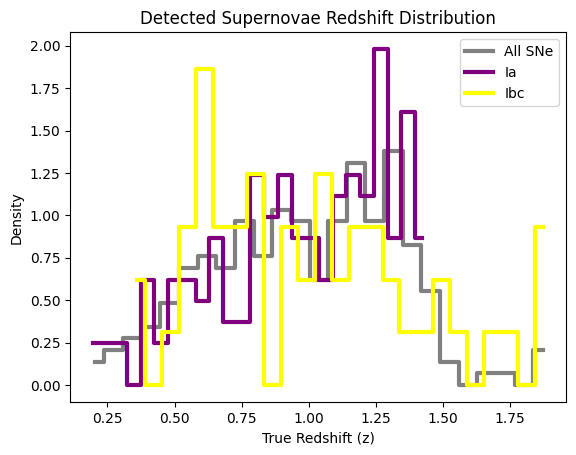

/tmp/ipykernel_1806125/361268567.py:44: RuntimeWarning: invalid value encountered in divide
  hist_det / hist_all,


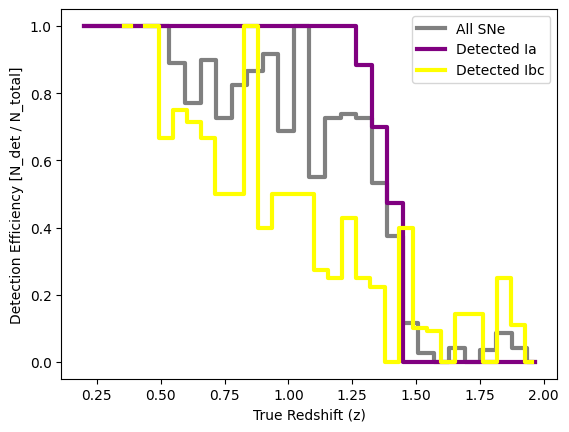

In [4]:
hist, bins = np.histogram(z[detected], bins=25, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, hist, drawstyle="steps-mid", label="All SNe", color="grey", linewidth=3)
hist, bins = np.histogram(z[detected][t[detected] == 0], bins=25, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, hist, drawstyle="steps-mid", label="Ia", color="purple", linewidth=3)
hist, bins = np.histogram(z[detected][t[detected] == 1], bins=25, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, hist, drawstyle="steps-mid", label="Ibc", color="yellow", linewidth=3)
plt.title("Detected Supernovae Redshift Distribution")
plt.xlabel("True Redshift (z)")
plt.ylabel("Density")
# plt.xscale("log")
plt.legend()
plt.show()

hist_all, bins = np.histogram(z, bins=30)
hist_det, bins = np.histogram(z[detected], bins=bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(
    bin_centers,
    hist_det / hist_all,
    drawstyle="steps-mid",
    label="All SNe",
    color="grey",
    linewidth=3,
)
hist_all, bins = np.histogram(z[t == 0], bins=30)
hist_det, bins = np.histogram(z[detected][t[detected] == 0], bins=bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(
    bin_centers,
    hist_det / hist_all,
    drawstyle="steps-mid",
    label="Detected Ia",
    color="purple",
    linewidth=3,
)
hist_all, bins = np.histogram(z[t == 1], bins=30)
hist_det, bins = np.histogram(z[detected][t[detected] == 1], bins=bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(
    bin_centers,
    hist_det / hist_all,
    drawstyle="steps-mid",
    label="Detected Ibc",
    color="yellow",
    linewidth=3,
)
plt.xlabel("True Redshift (z)")
plt.ylabel("Detection Efficiency [N_det / N_total]")
plt.legend()
plt.show()

## Construct posterior density

In [5]:
cosmo_mean = jnp.array([0.307, -1])  # Omega_m, w
cosmo_cov = jnp.array([[0.1, 0], [0, 1.0]])
cosmology.Omega_m.to_dynamic()
cosmology.w0.to_dynamic()

detect_Ia_mean = jnp.array([-4, 0.1])  # threshold, scale
detect_Ia_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ia.threshold.to_dynamic()
# detect_Ia.scale.to_dynamic()

detect_Ibc_mean = jnp.array([-4.1, 0.1])  # threshold, scale
detect_Ibc_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ibc.threshold.to_dynamic()
# detect_Ibc.scale.to_dynamic()

In [6]:
class Prior(ck.Module):
    def __init__(self, cosmology, detect, name=None):
        super().__init__(name=name)
        self.cosmology = cosmology
        self.detect = detect

    @ck.forward
    def log_prior(self):
        prior = 0
        # Cosmology prior
        params = jnp.array([self.cosmology.Omega_m.value, self.cosmology.w0.value])
        # diff = params - jnp.array(cosmo_mean)
        # exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(cosmo_cov, diff))
        # norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(cosmo_cov)[1])
        # prior = prior + norm + exponent
        prior = jnp.where(
            (params[0] <= 0) | (params[0] >= 1), -jnp.inf, prior
        )  # exclude unphysical Omega_m

        # Detect_Ia prior
        params = jnp.array([self.detect[0].threshold.value, self.detect[0].scale.value])
        diff = params - jnp.array(detect_Ia_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ia_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ia_cov)[1])
        prior = prior + norm + exponent

        # Detect_Ibc prior
        params = jnp.array([self.detect[1].threshold.value, self.detect[1].scale.value])
        diff = params - jnp.array(detect_Ibc_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ibc_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ibc_cov)[1])
        prior = prior + norm + exponent
        return prior


class Posterior(ck.Module):
    def __init__(self, likelihood, prior, name=None):
        super().__init__(name=name)
        self.likelihood = likelihood
        self.prior = prior

    @ck.forward
    def log_posterior(self):
        log_prior = self.prior.log_prior()
        log_likelihood = self.likelihood.log_likelihood()
        return log_prior + log_likelihood

In [7]:
posterior = Posterior(
    likelihood=cg.sn.ZMuLikelihood(
        cosmology,
        ratecombined=ratecombined,
        detect=[detect_Ia, detect_Ibc],
        mean=obs_meanD,
        cov=obs_covD * 0.8,
        var_bump=jnp.stack([jnp.diag(oc) for oc in obs_covD[0]], axis=0) * 0.2,
        name=f"likelihood",
    ),
    prior=Prior(cosmology, [detect_Ia, detect_Ibc]),
)

start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)

print(posterior)

-509.4627298709547
Time taken (s): 14.459137201309204
-509.4627298709547
Time taken (s): 1.1189162731170654
-509.4627298709547
Time taken (s): 1.3000800609588623
-509.4627298709547
Time taken (s): 1.350175380706787
Posterior|Posterior
    likelihood|ZMuLikelihood
        Cosmology|Cosmology
            H0|static: 67.9
            Omega_m|dynamic value: 0.307
            Omega_k|static: 0
            Omega_r|static: 0
            Omega_l|pointer
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
            w0|dynamic value: -1
            wa|static: 0
        CombinedSNRate|CombinedSNRate
            Cosmology|Cosmology
                H0|static: 67.9
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
                Omega_l|pointer
                    Omega_m|dynamic value: 0.307
                    Omega_k|static: 0
                    Omega_r|static: 0
        

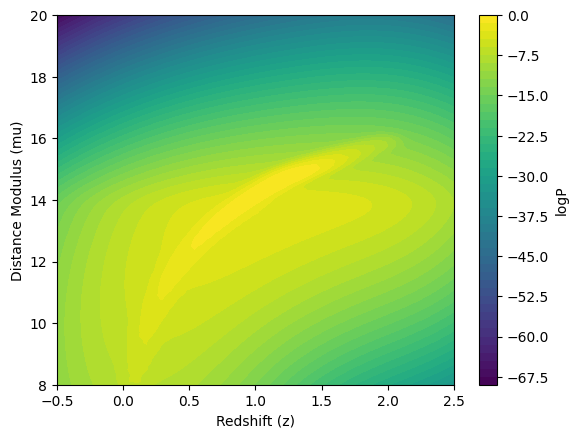

In [8]:
z_test = jnp.linspace(-0.5, 2.5, 50)
mu_test = jnp.linspace(8, 20, 100)
Z = jnp.stack(jnp.meshgrid(z_test, mu_test, indexing="ij"), axis=-1)
Lp = jax.vmap(posterior.likelihood.logP_Xd1, in_axes=(0, None, None))(
    Z.reshape(-1, 2), obs_covD[0], ()
).reshape(50, 100)
plt.contourf(z_test, mu_test, Lp.T, levels=50)
plt.colorbar(label="logP")
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (mu)")
plt.show()

In [ ]:
key, subkey = jax.random.split(key)
x_poly = cg.utils.superuniform(subkey, 50, 2, bounds=((0.01, -2.0), (0.5, -0.25)))
LZ_poly = cg.utils.vmap_chunked1d(
    lambda x: posterior.likelihood.logP_d1(posterior.likelihood.cov[0], x),
    chunk_size=5,
    prog_bar=True,
)(x_poly).block_until_ready()
res = cg.utils.tdp_regression(x_poly, LZ_poly, degree=4)
print(res)
LZ_poly_fit = cg.utils.tdp_evaluate(x_poly, res[0], res[1])
print(LZ_poly_fit - LZ_poly)
print(jnp.std(LZ_poly_fit - LZ_poly))

100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


(Array([-3.38102018e-01,  5.08052977e-01,  1.84568785e+00, -1.37046640e+01,
       -7.91772737e+00,  2.97869278e-01,  5.58480267e+01,  2.36621145e+01,
        1.46289843e+00,  1.18413563e-01, -6.14398628e+01, -2.20555600e+01,
        1.58839791e-01,  6.40863593e-01,  5.75481059e-02], dtype=float64), Array([[0, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 1],
       [0, 2],
       [3, 0],
       [2, 1],
       [1, 2],
       [0, 3],
       [4, 0],
       [3, 1],
       [2, 2],
       [1, 3],
       [0, 4]], dtype=int32))
[-6.56049635e-05 -2.38717951e-02 -4.00162621e-03 -1.42313918e-03
  1.30475689e-02 -1.59375216e-02  2.10832711e-03  6.23775683e-03
 -1.27610904e-02  7.33271539e-03 -1.79953830e-02 -8.12455762e-04
 -6.28648267e-03  8.87644578e-05  1.22230206e-02 -2.57786497e-02
 -6.51561218e-03 -1.29049799e-02  1.94355037e-02  1.59557670e-02
 -6.87853870e-03  8.42683854e-03  5.41063207e-03 -1.52721825e-02
 -9.10752104e-03  4.57814085e-03  8.02900086e-03 -8.00088460e-03
 -1.

In [10]:
N = 50
Om = jnp.linspace(0.01, 0.5, N)
Ow = jnp.linspace(-2, -0.25, N)
x = jnp.stack(jnp.meshgrid(Om, Ow, indexing="xy"), axis=-1)
LZ = (
    cg.utils.vmap_chunked1d(
        lambda x: posterior.likelihood.logP_d1(posterior.likelihood.cov[0], x),
        chunk_size=5,
        prog_bar=True,
    )(x.reshape(-1, 2))
    .reshape(N, N)
    .block_until_ready()
)

100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


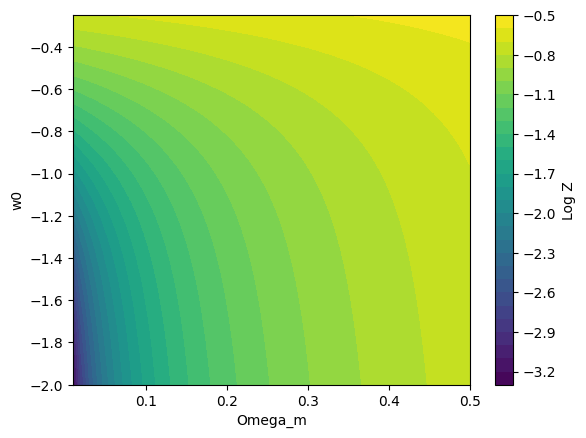

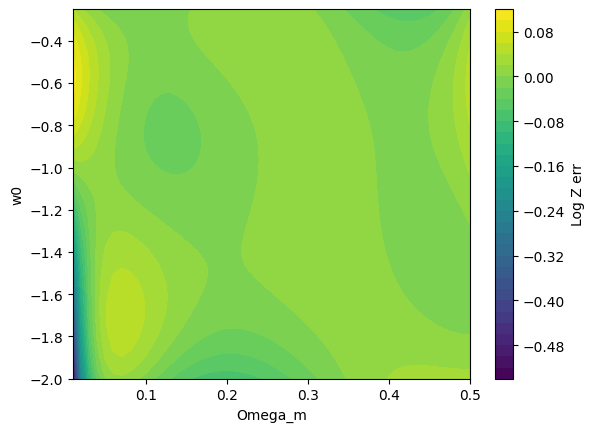

In [11]:
plt.contourf(Om, Ow, LZ, levels=32, cmap="viridis")
# plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
# plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Z")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()
LZ_poly = cg.utils.tdp_evaluate(x.reshape(-1, 2), res[0], res[1]).reshape(N, N)
plt.contourf(Om, Ow, LZ - LZ_poly, levels=32, cmap="viridis")
plt.colorbar(label="Log Z err")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [12]:
raise Exception()

Exception: 

In [ ]:
N = 50
Om = jnp.linspace(0.01, 0.5, N)
Ow = jnp.linspace(-2, -0.25, N)
x = jnp.stack(jnp.meshgrid(Om, Ow, indexing="xy"), axis=-1)
Lp = (
    cg.utils.vmap_chunked1d(posterior.log_posterior, chunk_size=5, prog_bar=True)(x.reshape(-1, 2))
    .reshape(N, N)
    .block_until_ready()
)

 18%|█▊        | 90/500 [00:15<01:08,  5.95it/s]


KeyboardInterrupt: 

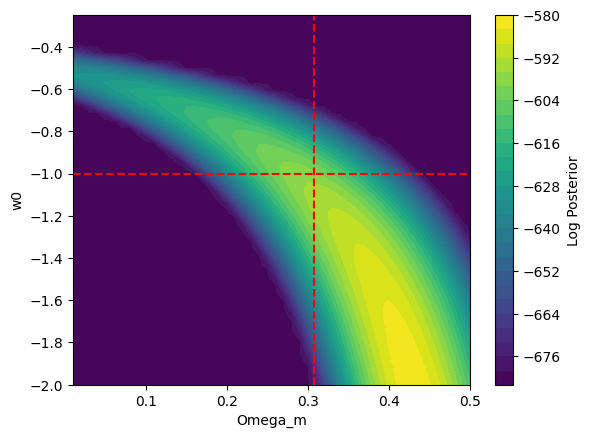

In [ ]:
plt.contourf(Om, Ow, jnp.clip(Lp, a_min=jnp.max(Lp) - 100), levels=32, cmap="viridis")
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Posterior")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [ ]:
print(Lp)

[[-2422.18994195 -2232.63661866 -2113.97241237 ...  -843.17160901
   -845.09437123  -848.24515861]
 [-2404.97840293 -2220.63483185 -2104.53632283 ...  -843.9699376
   -846.14561531  -849.52584726]
 [-2387.2635439  -2208.28760161 -2094.82724291 ...  -844.86613092
   -847.2973966   -850.90911146]
 ...
 [-1008.04965715 -1011.59209756 -1015.23532353 ... -1207.45034125
  -1211.11455686 -1214.72383698]
 [-1044.89423398 -1048.6701497  -1052.4953272  ... -1224.7795183
  -1227.86923456 -1230.9131541 ]
 [-1087.24921724 -1090.87373724 -1094.51051785 ... -1241.56350768
  -1244.10036398 -1246.60042966]]


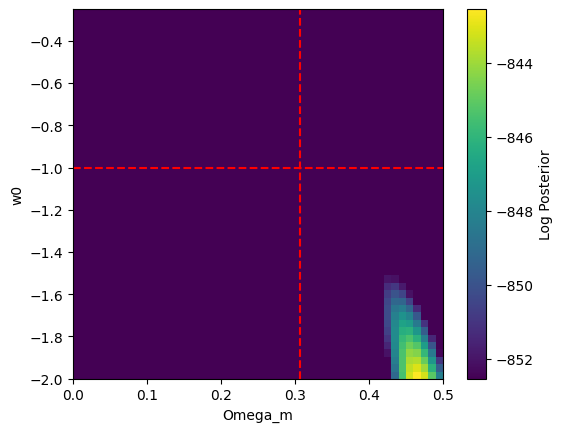

In [ ]:
plt.imshow(
    Lp,
    cmap="viridis",
    vmin=jnp.max(Lp) - 10,
    origin="lower",
    extent=(0, 0.5, -2, -0.25),
    interpolation="none",
)
plt.gca().set_aspect((0.5 - 0) / (-0.25 - -2))
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Posterior")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [ ]:
# raise Exception()

In [ ]:
posterior.likelihood.detect[0].threshold.to_dynamic()
posterior.likelihood.detect[0].scale.to_dynamic()
posterior.likelihood.detect[1].threshold.to_dynamic()
posterior.likelihood.detect[1].scale.to_dynamic()
posterior.likelihood.rate.sn_rates[0].r.to_dynamic()
posterior.likelihood.var_bump.to_dynamic()
x0 = posterior.build_params_array()
print(x0.shape)

chains = 16
key, subkey = jax.random.split(key)

# warmup
key, subkey = jax.random.split(key)
mass_matrix = (
    jnp.diag(
        jnp.array(
            [1, 1, 1e-3, 1, 1, 1, 1] + list(10 * posterior.likelihood.var_bump.value.flatten())
        )
    )
    ** 2
)
samples_burn = cg.utils.mala(
    jnp.repeat(x0[None, :], chains, axis=0),
    posterior.log_posterior,
    num_samples=500,
    epsilon=0.01,
    mass_matrix=mass_matrix,
    key=subkey,
    progress=True,
)
cov = jnp.cov(samples_burn.reshape(-1, samples_burn.shape[-1]).T)
print(cov.shape)

plt.plot(range(samples_burn.shape[0]), samples_burn[:, 0, 0], alpha=0.5, label="Omega_m, chain 0")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 1, 0], alpha=0.5, label="Omega_m, chain 1")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 2, 0], alpha=0.5, label="Omega_m, chain 2")
plt.xlabel("Sample")
plt.ylabel("Omega_m")
plt.title("Warmup")
plt.legend()
plt.show()

plt.plot(range(samples_burn.shape[0]), samples_burn[:, 0, 1], alpha=0.5, label="w0, chain 0")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 1, 1], alpha=0.5, label="w0, chain 1")
plt.plot(range(samples_burn.shape[0]), samples_burn[:, 2, 1], alpha=0.5, label="w0, chain 2")
plt.xlabel("Sample")
plt.ylabel("w0")
plt.title("Warmup")
plt.legend()
plt.show()

plt.plot(samples_burn[:, 0, 0], samples_burn[:, 0, 1], alpha=0.5, label="chain 0")
plt.plot(samples_burn[:, 1, 0], samples_burn[:, 1, 1], alpha=0.5, label="chain 1")
plt.plot(samples_burn[:, 2, 0], samples_burn[:, 2, 1], alpha=0.5, label="chain 2")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.title("Warmup")
plt.legend()
plt.show()

# production
key, subkey = jax.random.split(key)
samples_prod = cg.utils.mala(
    samples_burn[-1],
    posterior.log_posterior,
    mass_matrix=cov,
    num_samples=5000,
    epsilon=0.7,
    key=subkey,
    progress=True,
)

(11,)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x71a6f73ae570>>
Traceback (most recent call last):
  File "/home/connor/venvs/PY312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
MALA:   0%|          | 1/500 [00:05<48:11,  5.80s/it, acc_rate=1.00]


KeyboardInterrupt: 

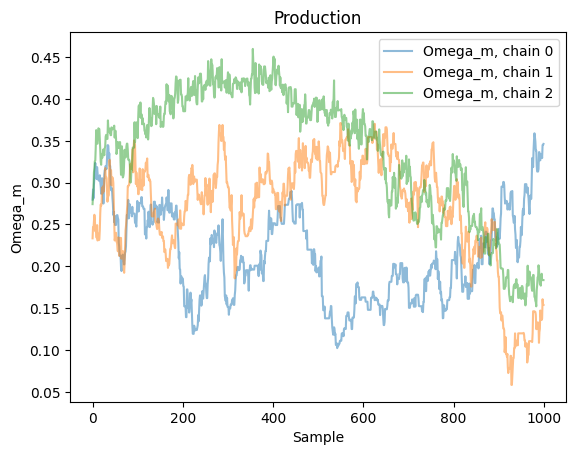

In [ ]:
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 0, 0], alpha=0.5, label="Omega_m, chain 0")
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 1, 0], alpha=0.5, label="Omega_m, chain 1")
plt.plot(range(samples_prod.shape[0]), samples_prod[:, 2, 0], alpha=0.5, label="Omega_m, chain 2")
plt.xlabel("Sample")
plt.ylabel("Omega_m")
plt.title("Production")
plt.legend()
plt.show()

In [ ]:
print(posterior.dynamic_params)
print(posterior)

(Omega_m, w0, r, threshold, scale, threshold, scale, var_bump)
Posterior|Posterior
    likelihood|ZMuLikelihood
        Cosmology|Cosmology
            H0|static: 67.9
            Omega_m|dynamic value: 0.307
            Omega_k|static: 0
            Omega_r|static: 0
            Omega_l|pointer
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
            w0|dynamic value: -1
            wa|static: 0
        CombinedSNRate|CombinedSNRate
            Cosmology|Cosmology
                H0|static: 67.9
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
                Omega_l|pointer
                    Omega_m|dynamic value: 0.307
                    Omega_k|static: 0
                    Omega_r|static: 0
                w0|dynamic value: -1
                wa|static: 0
            sn_rates|ntuple
                rateIa|SNRateConst
                    Cosmology|C

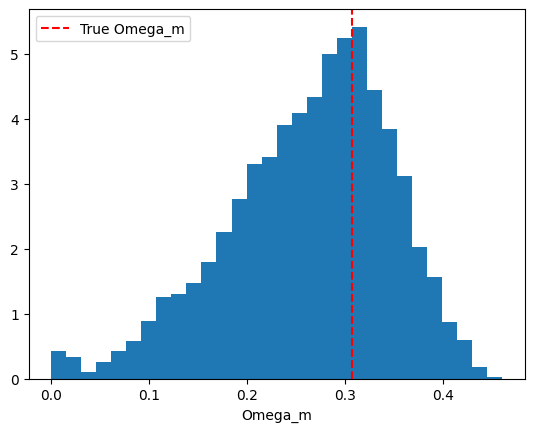

In [ ]:
plt.hist(samples_prod[:, :, 0].reshape(-1), bins=30, density=True)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.xlabel("Omega_m")
plt.legend()
plt.show()

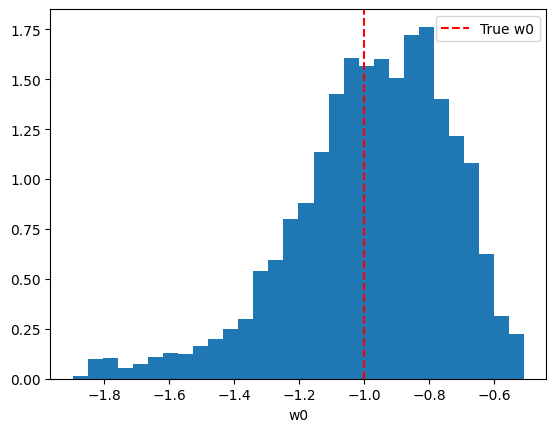

In [ ]:
plt.hist(samples_prod[:, :, 1].reshape(-1), bins=30, density=True)
plt.axvline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("w0")
plt.legend()
plt.show()

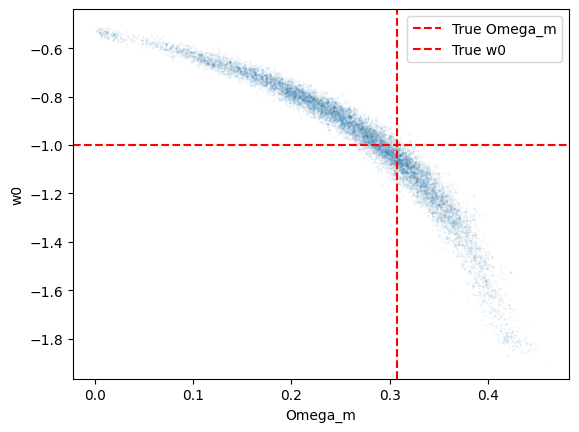

In [ ]:
plt.scatter(samples_prod[:, :, 0].reshape(-1), samples_prod[:, :, 1].reshape(-1), s=0.1, alpha=0.1)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.legend()
plt.show()

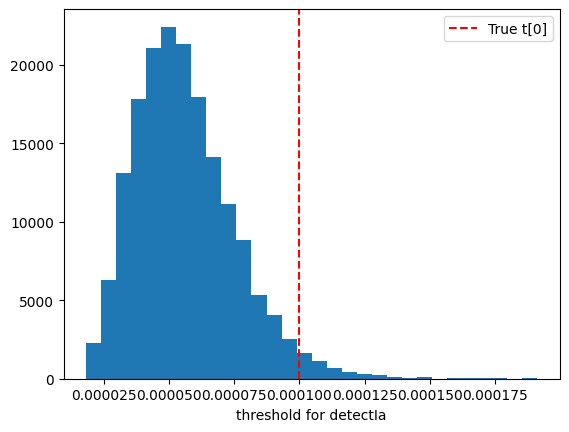

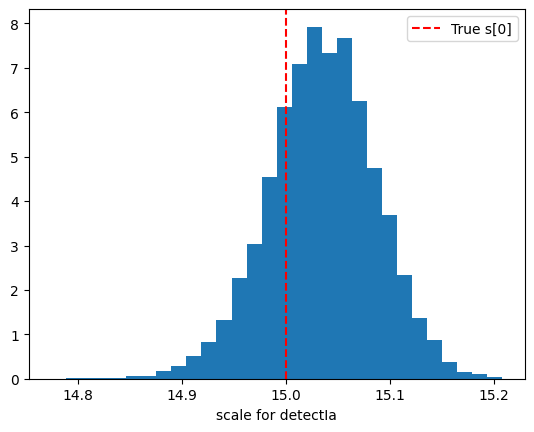

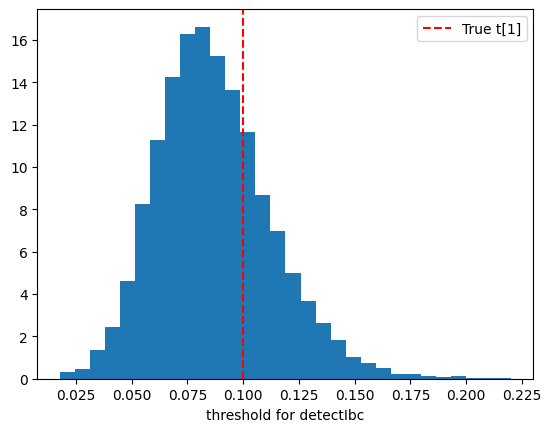

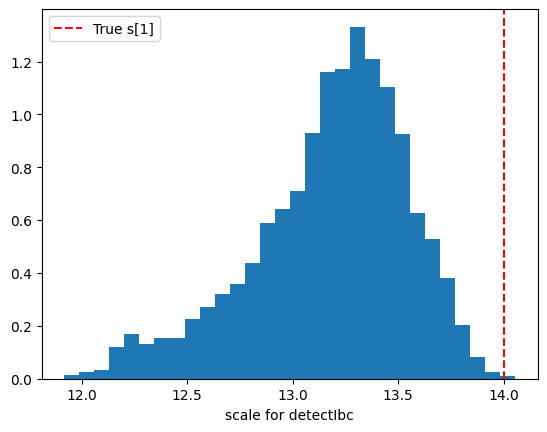

In [ ]:
for i in range(len(posterior.likelihood.detect)):
    plt.hist(samples_prod[:, :, 2 + i * 2].reshape(-1), bins=30, density=True)
    plt.axvline(x0[2 + i * 2], color="r", linestyle="--", label=f"True t[{i}]")
    plt.xlabel(f"threshold for {posterior.likelihood.detect[i].name}")
    plt.legend()
    plt.show()

    plt.hist(samples_prod[:, :, 3 + i * 2].reshape(-1), bins=30, density=True)
    plt.axvline(x0[3 + i * 2], color="r", linestyle="--", label=f"True s[{i}]")
    plt.xlabel(f"scale for {posterior.likelihood.detect[i].name}")
    plt.legend()
    plt.show()

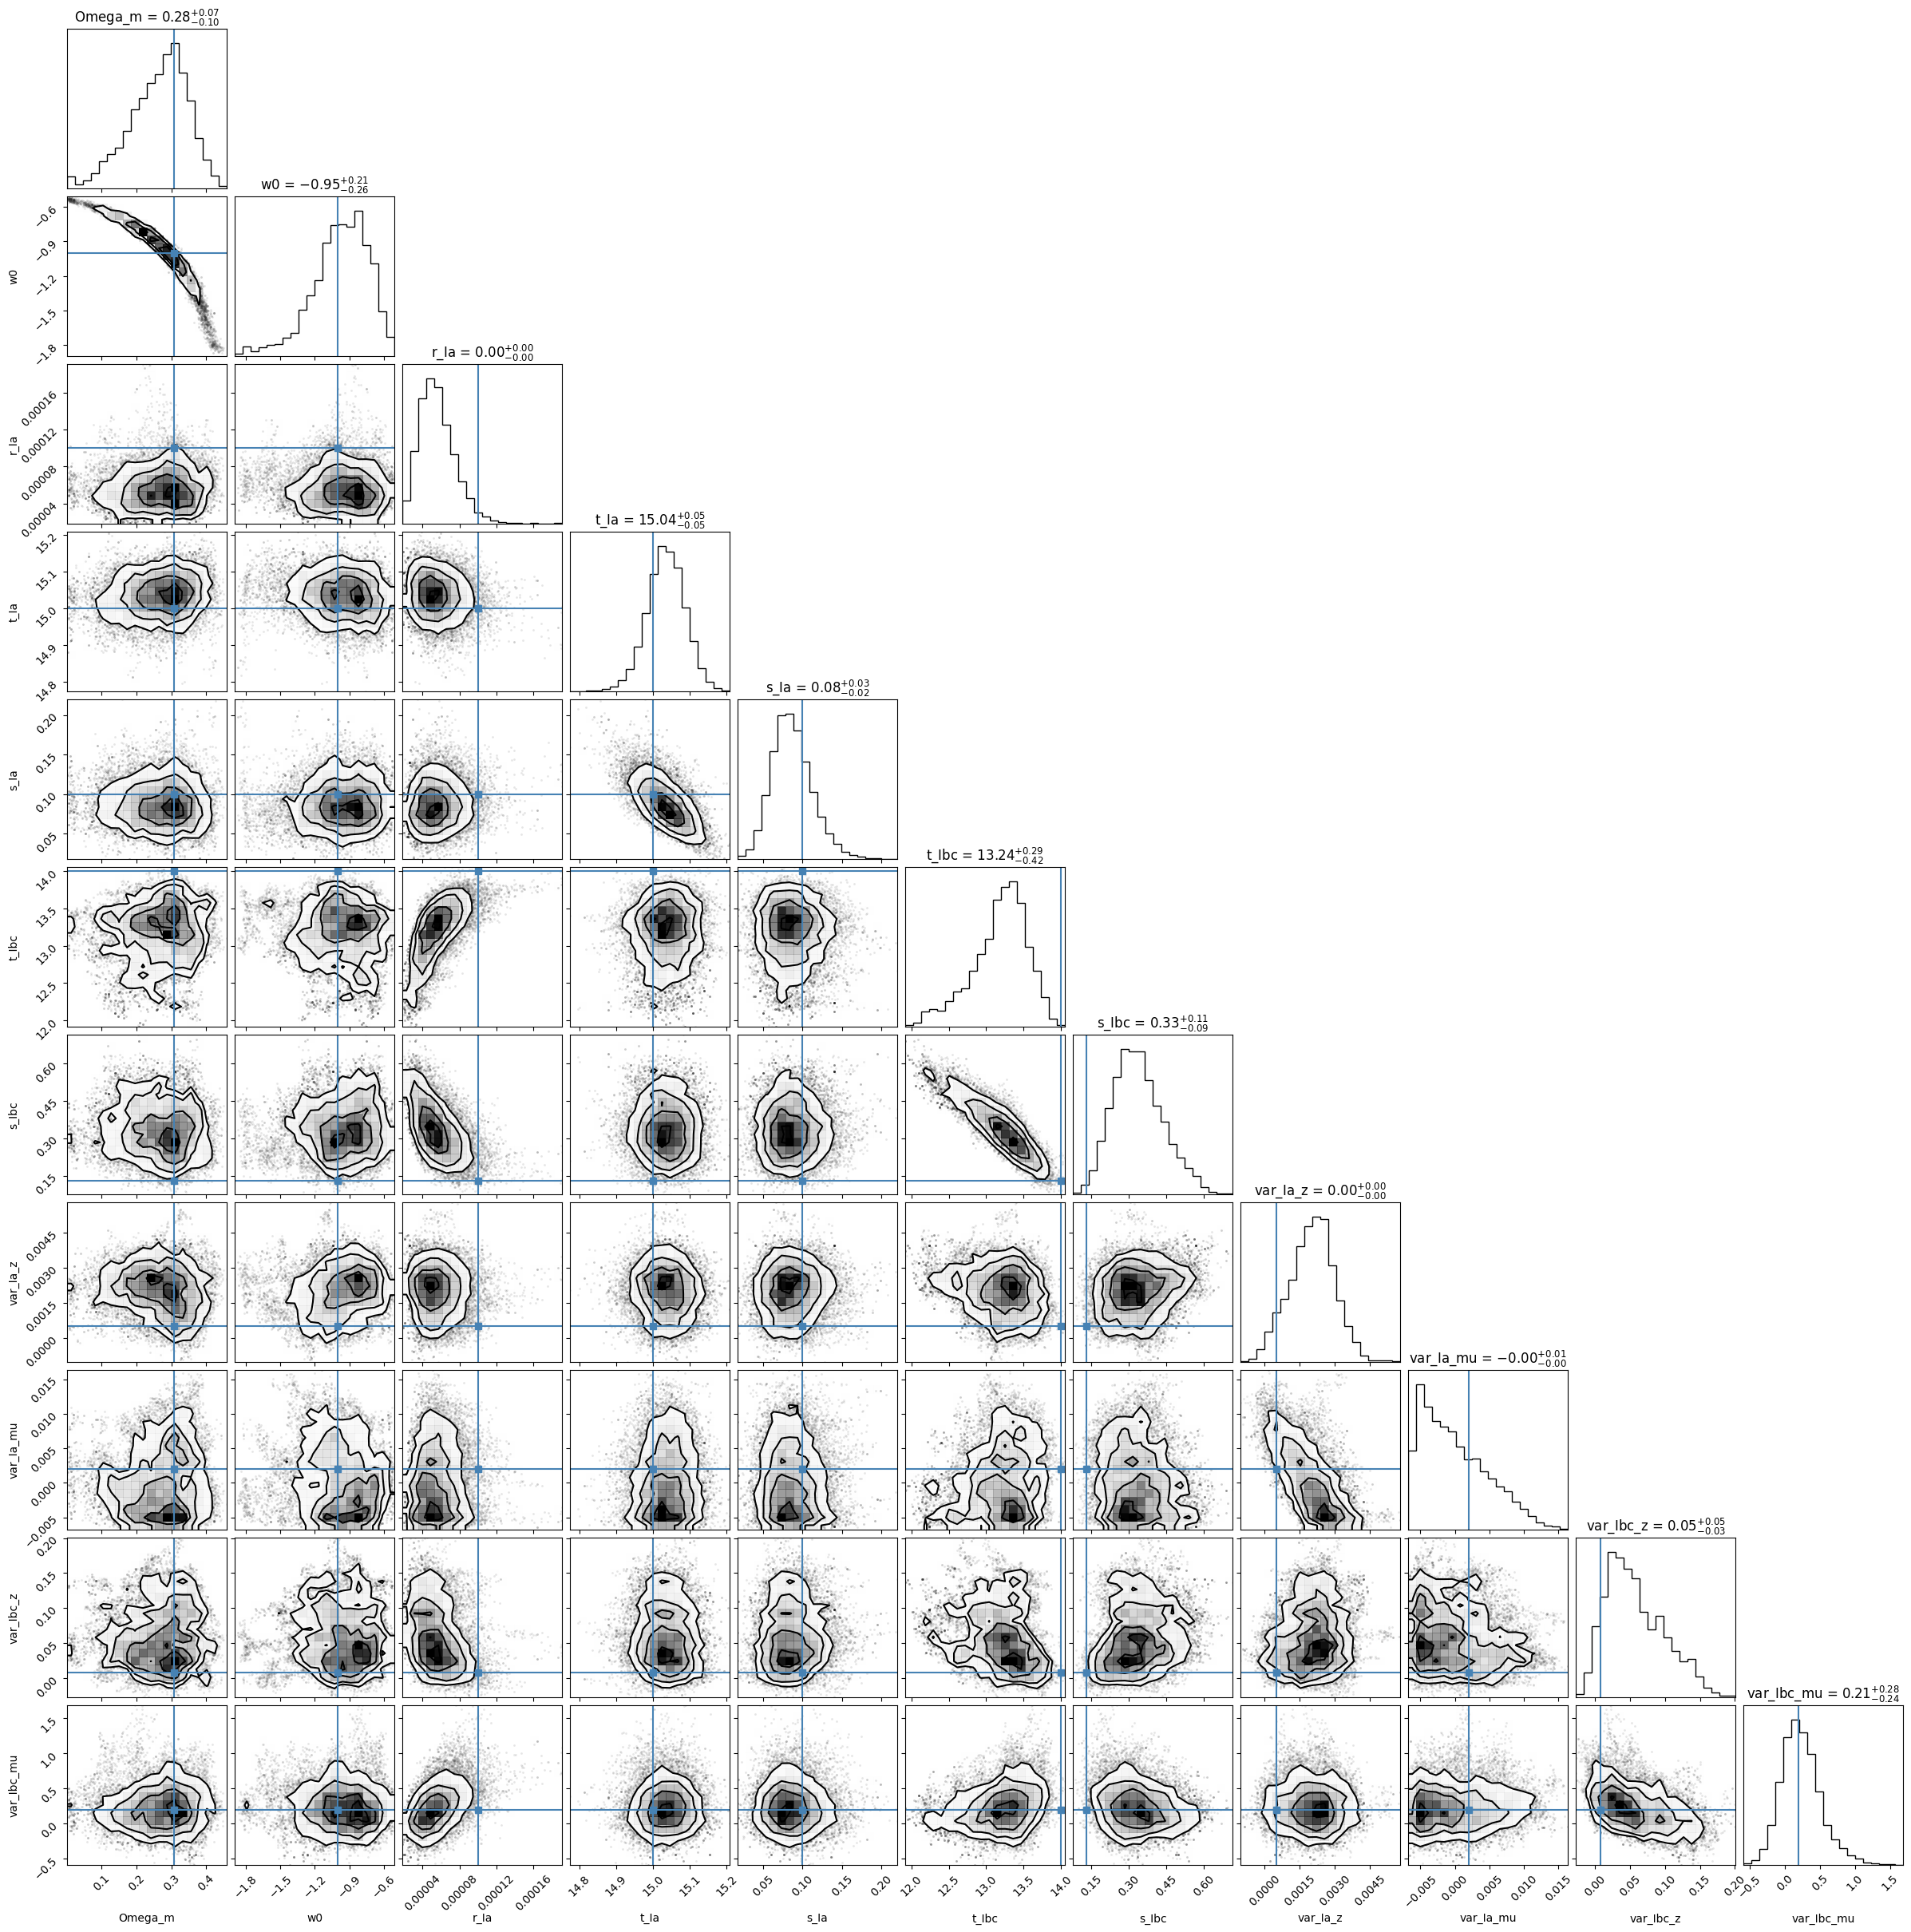

In [ ]:
figure = corner.corner(
    data=np.array(samples_prod.reshape(-1, samples_prod.shape[-1])),
    labels=[
        "Omega_m",
        "w0",
        "r_Ia",
        "t_Ia",
        "s_Ia",
        "t_Ibc",
        "s_Ibc",
        "var_Ia_z",
        "var_Ia_mu",
        "var_Ibc_z",
        "var_Ibc_mu",
    ],
    show_titles=True,
    truths=x0,
)